# Agent Speed Calibration

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import anderson, shapiro

%matplotlib inline

## Paths and Directories

In [2]:
combined_frames_path = '../data/outputs/combined_frames.csv'

## Functions

In [3]:
def get_distance(x0, y0, x1, y1):
    x_diff = x1 - x0
    y_diff = y1 - y0
    return sqrt(x_diff*x_diff + y_diff*y_diff)

In [8]:
def get_speed_profile(x_coordinates, y_coordinates):
    assert len(x_coordinates) == len(y_coordinates)
    
    FRAMES_PER_SECOND = 25
    PIXELS_PER_METRE = 14
    ratio = FRAMES_PER_SECOND / PIXELS_PER_METRE
    
    distances = list()
    for i in range(len(x_coordinates) - 1):
        x0, x1 = x_coordinates[i], x_coordinates[i + 1]
        y0, y1 = y_coordinates[i], y_coordinates[i + 1]
        distances.append(get_distance(x0, y0, x1, y1))
    
    speeds = [distance * ratio for distance in distances]
    speeds = [speed for speed in speeds if (speed != 0 and speed < 10)]
    
    total_distance = get_distance(x_coordinates[0], y_coordinates[0],
                                  x_coordinates[-1], y_coordinates[-1])
    average_speed = ratio * total_distance / (len(x_coordinates) - 1)
    
    mean_speed = np.mean(speeds)
    
    return speeds, average_speed, mean_speed

## Analysis

In [4]:
frames_data = pd.read_csv(combined_frames_path)
frames_data.head()

,frame,pedestrianID,x,y
0,4506,245,456.903221,507.182260
1,4506,246,447.735569,490.672126
2,4506,247,466.788192,520.933037
3,4506,248,475.195786,527.601525
4,4506,249,281.777398,518.092819


In [5]:
pedestrian_ids = frames_data['pedestrianID'].unique()
pedestrian_ids = sorted(pedestrian_ids)

In [6]:
pedestrian_trajectories = dict()

for pid in pedestrian_ids:
    df = frames_data.loc[frames_data['pedestrianID']==pid, :]
    df = df.sort_values(by='frame')
    d = {'xs': list(df['x']),
         'ys': list(df['y'])}
    pedestrian_trajectories[pid] = d

In [7]:
print(len(pedestrian_trajectories))

274


In [9]:
for trajectory in pedestrian_trajectories.values():
    speed, average_speed, mean_speed = get_speed_profile(trajectory['xs'], trajectory['ys'])
    trajectory['speed'] = speed
    trajectory['average_speed'] = average_speed
    trajectory['mean_speed'] = mean_speed

In [12]:
# Make list of average speeds excluding 0s
average_speeds = [d['average_speed'] for d in pedestrian_trajectories.values()]
average_speeds = [speed for speed in average_speeds if speed != 0]

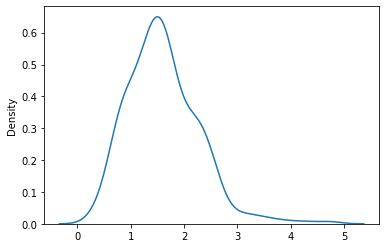

In [17]:
plt.figure()
sns.kdeplot(x=average_speeds)
plt.show()

In [19]:
speed_samples = np.random.normal(loc=np.mean(average_speeds),
                                 scale=np.std(average_speeds),
                                 size=len(average_speeds))

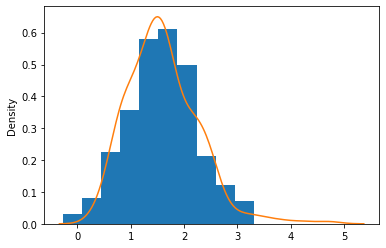

In [23]:
plt.figure()
plt.hist(speed_samples, density=True)
sns.kdeplot(average_speeds)
plt.show()